In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.linear_model import LinearRegression


device = torch.device("cuda")


In [31]:
# parameters
h1 = 5
h2 = 100
W = np.array([1 if np.random.rand() > 0.5 else -1 for _ in range(h2)])
W = torch.from_numpy(W).float().to(device)
n_epoch = 1000
lr = 0.0002

In [79]:
def calcH_min_eig(X):
    n = len(X)
    H = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            if i == j:
                H[i][j] = 0.5
            else:
                H[i][j] = X[i].dot(X[j]) * (0.5 - np.arccos(X[i].dot(X[j])) / (2 * np.pi))
    return H, np.linalg.eig(H), min(np.linalg.eig(H)[0])

In [37]:
# data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

ind = []
N = 50
n = 0
while n < N:
    index = np.random.randint(60000)
    if trainset.train_labels[index].item() == 0:
        n += 1
        ind.append(index)
n = 0
while n < N:
    index = np.random.randint(60000)
    if trainset.train_labels[index].item() == 1:
        n +=1
        ind.append(index)
print('samples:', ind)

trainset.train_data = trainset.train_data[ind].float()
trainset.train_labels = trainset.train_labels[ind]
trainset.train_data = trainset.train_data.view(-1, 28*28)

for i in range(2*N):
    trainset.train_data[i] = trainset.train_data[i] / float(np.linalg.norm(trainset.train_data[i]))

H, H_eig, lambda0 = calcH_min_eig(trainset.train_data.numpy())
print('\lambda_0:', lambda0)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)

samples: [24440, 23277, 56914, 13921, 27283, 8449, 2353, 12134, 41635, 39075, 39944, 19542, 1709, 12264, 24809, 44958, 29599, 24388, 12020, 33496, 53424, 7786, 18832, 24367, 41126, 25952, 55922, 40421, 13238, 22429, 59241, 24148, 3049, 22658, 50444, 2493, 22373, 5074, 42324, 20840, 24188, 51228, 45669, 5203, 53632, 59680, 53038, 1664, 15798, 47289, 59041, 36085, 5107, 2012, 19421, 41031, 40362, 59882, 36892, 44988, 37305, 25129, 24328, 10290, 53521, 37441, 18493, 29999, 42205, 28622, 21740, 50632, 54809, 49441, 24762, 26772, 54968, 24606, 31377, 11975, 24714, 19282, 29375, 11728, 8550, 52807, 18940, 34723, 46685, 15999, 1242, 54803, 31843, 1394, 4507, 8394, 59954, 33394, 15809, 16591]
\lambda_0: 0.09653695707292308


In [38]:
# 2-layer network
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(28*28, h2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = W.dot(x)
        return x


# 3-layer network
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(28*28, h1)
        self.fc2 = nn.Linear(h1, h2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = W.dot(x)
        return x

In [39]:
net = Net2().to(device)
criterion = nn.MSELoss()


# train
Loss_record = []
optimizer = optim.SGD(net.parameters(), lr=lr)

for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(zip(trainset.train_data, trainset.train_labels)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 50 == 0:
        print('%d loss: %.8f' % (epoch + 1, running_loss))
    Loss_record.append(running_loss)

print('Finished Training')

50 loss: 0.73098815
100 loss: 0.39775573
150 loss: 0.24955467
200 loss: 0.17146626
250 loss: 0.12355634
300 loss: 0.09102889
350 loss: 0.06891026
400 loss: 0.05364899
450 loss: 0.04274417
500 loss: 0.03478975
550 loss: 0.02884204
600 loss: 0.02405757
650 loss: 0.02031539
700 loss: 0.01732231
750 loss: 0.01489762
800 loss: 0.01290200
850 loss: 0.01126003
900 loss: 0.00988180
950 loss: 0.00871864
1000 loss: 0.00772117
Finished Training


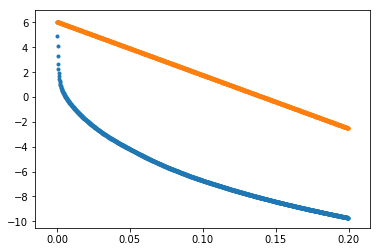

In [135]:
x_axis = np.array([lr * i for i in range(len(Loss_record))])
plt.scatter(x_axis, [np.log(l ** 2) for l in Loss_record], marker='.')
#plt.scatter(x_axis, Loss_record[0] ** 2 * np.exp(- 2000 * lambda0 * x_axis), marker='.')
plt.scatter(x_axis, [np.log(Loss_record[0] ** 2 * (1 - 2000 * lr * lambda0 / 2) ** k) for k, l in enumerate(Loss_record)], marker='.')
plt.show()

In [81]:
lambda0

0.042737480839052135

In [89]:
def fit_rate(y):
    # y^2 = y[0]^2 * exp(-t*x), want t
    return sum([np.log(y[k-1] / y[k]) * 2 / lr for k in range(1, len(y))]) / (len(y)-1)
print(fit_rate(Loss_record), lambda0)
print(np.exp(-fit_rate(Loss_record)), np.exp(-lambda0))

79.0226111516719 0.042737480839052135
4.7964070343889084e-35 0.9581628931721612


In [84]:
def fit_rate_discrete(y):
    # y[k]^2 = y[0]^2 * t^k, want t
    return sum([(y[k] ** 2 / y[k-1] ** 2) for k in range(1, len(y))]) / (len(y)-1)
print(fit_rate_discrete(Loss_record), 1-lr*lambda0/2)
print(1-fit_rate_discrete(Loss_record), lr*lambda0/2)

0.9856321450920335 0.9999957262519161
0.014367854907966549 4.273748083905213e-06


In [117]:
v = np.random.normal(size=2*N)
-2*v.T.dot(H).dot(v), -lambda0 * np.linalg.norm(v)**2

(-130.86562321131228, -4.609733157613707)

In [125]:
sorted(np.linalg.eig(H[:50,:50])[0]),sorted(np.linalg.eig(H)[0])

([0.07100952883971211,
  0.07507050665078678,
  0.07714860125929116,
  0.08170885939440649,
  0.08807127684585632,
  0.08961542924258217,
  0.09078171280319725,
  0.09909409114178108,
  0.10285859048878536,
  0.10879802236860298,
  0.11165580461495472,
  0.11484589879617527,
  0.11894817379496073,
  0.12091971582924207,
  0.12556351769676186,
  0.12672590325263433,
  0.12920069457951966,
  0.1323226563701354,
  0.1410595220764159,
  0.14676378988516128,
  0.1502701284382424,
  0.15460897655917466,
  0.15733908400585256,
  0.15851952807923508,
  0.16741094792964684,
  0.17107377662046266,
  0.1794784726888585,
  0.19382631204122658,
  0.1989048647213803,
  0.20593841759746484,
  0.2074123149257521,
  0.21135223187456412,
  0.23379438362384677,
  0.24317217276918998,
  0.260939624939502,
  0.27818189355047224,
  0.2912721183647713,
  0.3196007791644608,
  0.35740115701992975,
  0.37577652226278335,
  0.39321214152385153,
  0.45812457228737485,
  0.46441792407800836,
  0.5188248710126195,

In [128]:
print(np.linalg.eig(np.array([[0.5,0.3],[0.3,0.4]]))[0], 
np.linalg.eig(np.array([[0.5,0.5,0.3,0.3],[0.5,0.5,0.3,0.3],[0.3,0.3,0.4,0.4],[0.3,0.3,0.4,0.4]]))[0])

[0.75413813 0.14586187] [ 1.50827625e+00  2.91723747e-01  3.67742569e-19 -1.03346167e-16]


In [129]:
Loss_record

[20.709019787712577,
 11.617612552072387,
 7.737903840793479,
 5.205073040621073,
 3.814532786371899,
 3.042541790858195,
 2.5874770505931792,
 2.2935012840387117,
 2.0837682231169765,
 1.929511338348675,
 1.8089502056727724,
 1.7133729270677804,
 1.631042785014106,
 1.5600917627941726,
 1.4979975457403043,
 1.4429004535113563,
 1.3956284980713463,
 1.3520049529872864,
 1.3135314009705974,
 1.2780993232073001,
 1.243847210734387,
 1.2124802884094947,
 1.183234800984792,
 1.1554887530019187,
 1.1287409962174024,
 1.1037432016219242,
 1.0805590101431903,
 1.0584436419585472,
 1.03672016298097,
 1.0163274945365401,
 0.997069384867018,
 0.9785045619000812,
 0.9608673306793492,
 0.9436599291218499,
 0.9265428341873303,
 0.9098596617096177,
 0.8947893460476735,
 0.878531048227245,
 0.8645169081170252,
 0.8497968093588497,
 0.8361083502332303,
 0.8235601981507443,
 0.8101835961120969,
 0.7976834557685208,
 0.7859669806389036,
 0.7739809233261212,
 0.763054542853979,
 0.7517434439105273,
 0.74